## Predicting Medical Costs with Regression

We are using a kaggle data set in this exercise to predict costs associated with a patients traits such as age, smoker etc. We will be using regression models for our predictions.

Let's get started with importing the packages fom python we will need

In [45]:
#data visualization
import chart_studio.plotly as py
from plotly import tools
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [46]:
#statistics
from scipy.stats import norm
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from scipy import stats

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [47]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [48]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

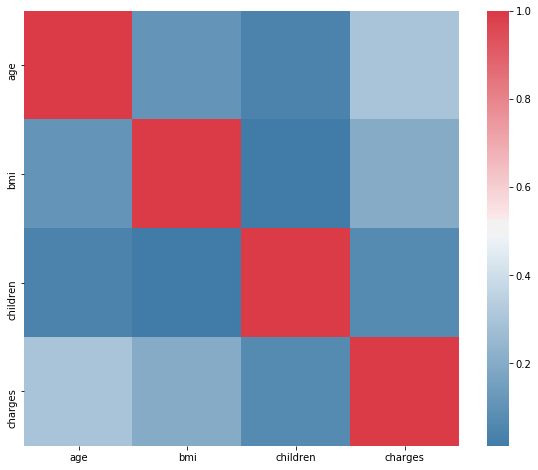

In [49]:
#lets see what we can gleam from an initial correlation heatmap
f, ax = pl.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240,10,as_cmap=True),
            square=True, ax=ax)

As expected a very high correlation exists between a patient who is a smoker and their charges.

Let's graph the distribution of charges as well as normalize the chart to account for outliers.

In [50]:
#kernel credit Janio Martinez
charge_dist = data['charges'].values
logcharge = np.log(data['charges'])

trace0 = go.Histogram(
    x=charge_dist,
    histnorm='probability',
    name="Charges Distribution",
    marker = dict(
        color = '#FA5858',
    )
)
trace1 = go.Histogram(
    x=logcharge,
    histnorm='probability',
    name="Charges Distribution using Log",
    marker = dict(
        color = '#58FA82',
    )
)
fig = tools.make_subplots(rows=2, cols=1,
                          subplot_titles=('Charge Distribution','Log Charge Distribution'),
                         print_grid=False)



fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)


fig['layout'].update(showlegend=True, title='Charge Distribution', bargap=0.05)
iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

Let's graph the distribution of smokers among gender

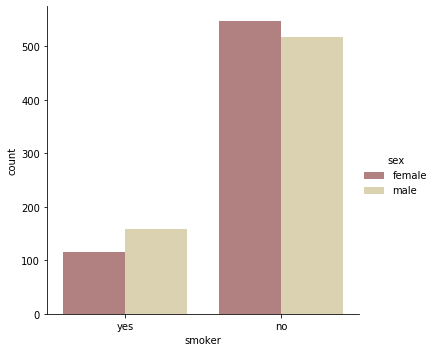

In [51]:
sns.catplot(x="smoker", kind="count",hue = 'sex', palette="pink", data=data)

Let's have a look at how gender may affect charges using box plots from seaborn

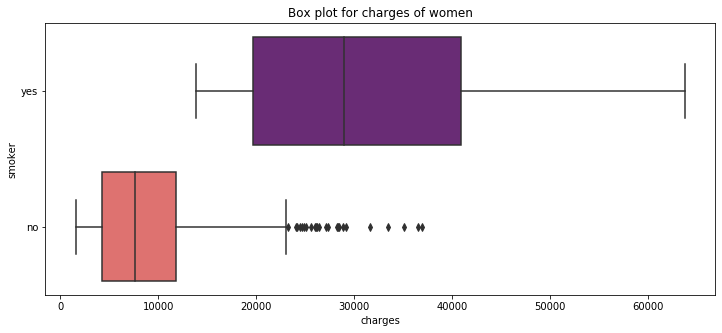

In [52]:
pl.figure(figsize=(12,5))
pl.title("Box plot for charges of women")
sns.boxplot(y="smoker", x="charges", data =  data[(data.sex == 'female')] , orient="h", palette = 'magma')

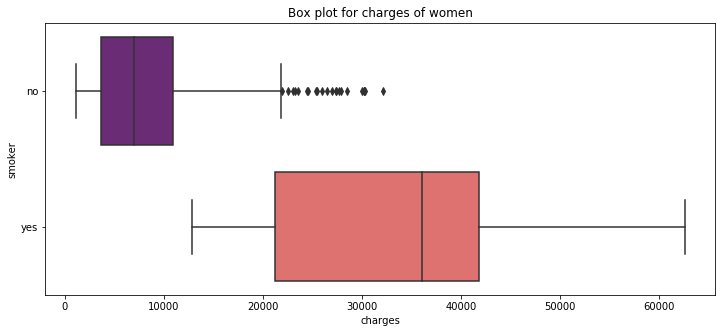

In [53]:
pl.figure(figsize=(12,5))
pl.title("Box plot for charges of women")
sns.boxplot(y="smoker", x="charges", data =  data[(data.sex == 'male')] , orient="h", palette = 'magma')

Let's visualize how age and amount charged are affected

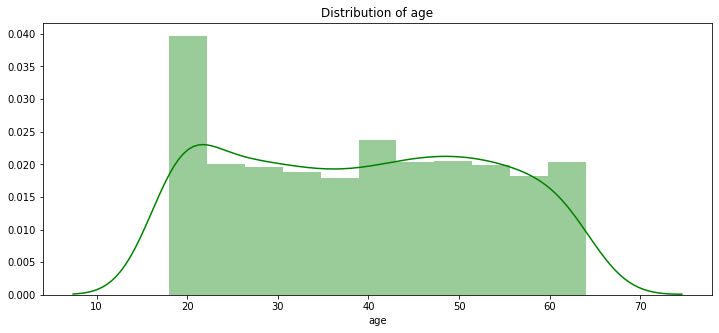

In [54]:
pl.figure(figsize=(12,5))
pl.title("Distribution of age")
ax = sns.distplot(data["age"], color = 'g')

Distribution of BMI across our dataset

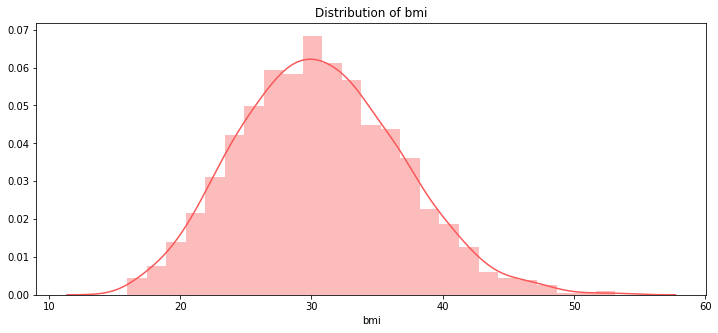

In [55]:
pl.figure(figsize=(12,5))
pl.title("Distribution of bmi")
ax = sns.distplot(data["bmi"], color = '#FA5858')

Let's bin by age groups to focus in on the relationshio between age and BMI

In [56]:
#references Janio MArtinez Kaggle "Patient Charges" kernel
data['age_cat'] = np.nan
lst = [data]

for col in lst:
    col.loc[(col['age'] >= 18) & (col['age'] <= 35), 'age_cat'] = 'Young Adult'
    col.loc[(col['age'] > 35) & (col['age'] <= 55), 'age_cat'] = 'Senior Adult'
    col.loc[col['age'] > 55, 'age_cat'] = 'Elder'

young_adults = data["bmi"].loc[data["age_cat"] == "Young Adult"].values
senior_adult = data["bmi"].loc[data["age_cat"] == "Senior Adult"].values
elders = data["bmi"].loc[data["age_cat"] == "Elder"].values

trace0 = go.Box(
    y=young_adults,
    name = 'Young Adults',
    boxmean= True,
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )
)
trace1 = go.Box(
    y=senior_adult,
    name = 'Senior Adults',
    boxmean= True,
    marker = dict(
        color = 'rgb(0, 128, 128)',
    )
)

trace2 = go.Box(
    y=elders,
    name = 'Elders',
    boxmean= True,
    marker = dict(
        color = 'rgb(247, 186, 166)',
    )
)

In [57]:
trdata = [trace0, trace1, trace2]

layout = go.Layout(title="Body Mass Index <br> by Age Category", xaxis=dict(title="Age Category", titlefont=dict(size=16)),
                  yaxis=dict(title="Body Mass Index", titlefont=dict(size=16)))

fig = go.Figure(data=trdata, layout=layout)
iplot(fig)

Now let's bin the BMI into weight categories to focus on its relationship to charges

In [58]:
#credit Janio MArtinez kernel

data["weight_condition"] = np.nan
lst = [data]

for col in lst:
    col.loc[col["bmi"] < 18.5, "weight_condition"] = "Underweight"
    col.loc[(col["bmi"] >= 18.5) & (col["bmi"] < 24.986), "weight_condition"] = "Normal Weight"
    col.loc[(col["bmi"] >= 25) & (col["bmi"] < 29.926), "weight_condition"] = "Overweight"
    col.loc[col["bmi"] >= 30, "weight_condition"] = "Obese"
    
data.head()

,age,sex,bmi,children,smoker,region,charges,age_cat,weight_condition
0,19,female,27.900,0,yes,southwest,16884.92400,Young Adult,Overweight
1,18,male,33.770,1,no,southeast,1725.55230,Young Adult,Obese
2,28,male,33.000,3,no,southeast,4449.46200,Young Adult,Obese
3,33,male,22.705,0,no,northwest,21984.47061,Young Adult,Normal Weight
4,32,male,28.880,0,no,northwest,3866.85520,Young Adult,Overweight


In [59]:
fig = ff.create_facet_grid(
    data,
    x='age',
    y='charges',
    color_name='weight_condition',
    show_boxes=False,
    marker={'size': 10, 'opacity': 1.0},
    colormap={'Underweight': 'rgb(208, 246, 130)', 'Normal Weight': 'rgb(166, 246, 130)',
             'Overweight': 'rgb(251, 232, 238)', 'Obese': 'rgb(253, 45, 28)'}
)
251, 232, 238


fig['layout'].update(title="Weight Status vs Charges", width=800, height=600, plot_bgcolor='rgb(251, 251, 251)', 
                     paper_bgcolor='rgb(255, 255, 255)')


iplot(fig, filename='facet - custom colormap')

There are clear linear relationships between age and weight in relation to charges as we could have guessed

Next we'll just add smoking into the mix via linear models to further see its relationship to age and bmi.

Text(0.5, 1, 'Smokers and non-smokers')

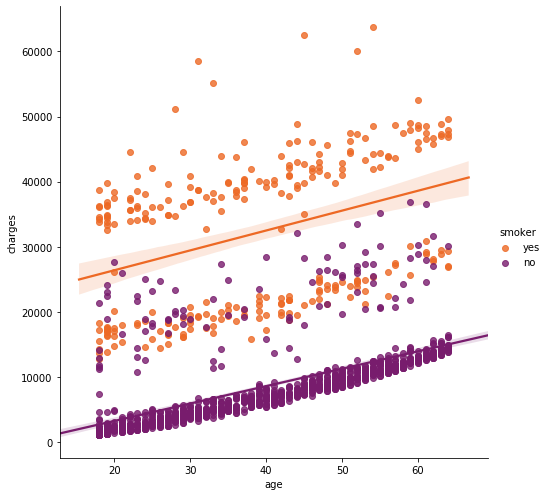

In [60]:
sns.lmplot(x="age", y="charges", hue="smoker", data=data, palette = 'inferno_r', size = 7)
ax.set_title('Smokers and non-smokers')

Text(0.5, 1, 'Smokers and non-smokers')

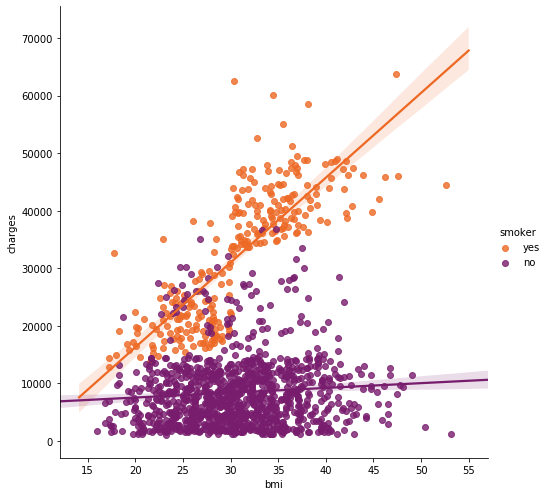

In [61]:
sns.lmplot(x="bmi", y="charges", hue="smoker", data=data, palette = 'inferno_r', size = 7)
ax.set_title('Smokers and non-smokers')

We already knew from our correlation matrix that smoking was a heavy indicator of charges but now we see that it compounds the likelihood when paired with older patients with higher BMI

## Machine Learning

We are ready to begin some unsupervised machine learning using Linear regression and random forest models

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor

Pre-processing our data

In [72]:
from sklearn.preprocessing import LabelEncoder
#sex
le = LabelEncoder()
le.fit(orig_data.sex.drop_duplicates()) 
orig_data.sex = le.transform(orig_data.sex)
# smoker or not
le.fit(orig_data.smoker.drop_duplicates()) 
orig_data.smoker = le.transform(orig_data.smoker)
#region
le.fit(orig_data.region.drop_duplicates()) 
orig_data.region = le.transform(orig_data.region)

Split our data into training and testing sets

In [73]:
x = orig_data.drop(['charges'], axis = 1)
y = orig_data.charges

x_train,x_test,y_train,y_test = train_test_split(x,y, random_state = 0)
lr = LinearRegression().fit(x_train,y_train)

y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

print(lr.score(x_test,y_test))

0.7962732059725786


In [76]:
X = orig_data.drop(['charges','region'], axis = 1)
Y = orig_data.charges

quad = PolynomialFeatures (degree = 2)
x_quad = quad.fit_transform(X)

X_train,X_test,Y_train,Y_test = train_test_split(x_quad,Y, random_state = 0)

plr = LinearRegression().fit(X_train,Y_train)

Y_train_pred = plr.predict(X_train)
Y_test_pred = plr.predict(X_test)

print(plr.score(X_test,Y_test))

0.8849197344147237


In [77]:
forest = RandomForestRegressor(n_estimators = 100,
                              criterion = 'mse',
                              random_state = 1,
                              n_jobs = -1)
forest.fit(x_train,y_train)
forest_train_pred = forest.predict(x_train)
forest_test_pred = forest.predict(x_test)

print('MSE train data: %.3f, MSE test data: %.3f' % (
mean_squared_error(y_train,forest_train_pred),
mean_squared_error(y_test,forest_test_pred)))
print('R2 train data: %.3f, R2 test data: %.3f' % (
r2_score(y_train,forest_train_pred),
r2_score(y_test,forest_test_pred)))

MSE train data: 3729086.094, MSE test data: 19933823.142
R2 train data: 0.974, R2 test data: 0.873


We got some good results with random forest and linear regression models. It would be beneficial however to have more data to account for since this sample set is rather small in terms of features!